SARIMA MODEL:

In [2]:
# import yahoo finance data
import yfinance as yf
# import stockstats data
from stockstats import StockDataFrame as ss

# import necessary libraries
import matplotlib as mp
import numpy as np
import pandas as pd
import pytz
import warnings
import time
import random
import statistics
import pydoc
import os
import pyarrow
import pandas_gbq
import statsmodels
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import sqlite3

#import libraries for SARIMA model
import pmdarima as pm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pickle as pkl
from datetime import datetime
from datetime import timedelta
from datetime import date

In [3]:
'''
apple_data = yf.download("AAPL", start = '2010-01-01', interval = '1d')
apple_df = ss.retype(apple_data)

apple_data[['stochrsi', 'macd', 'mfi']] = apple_df[['stochrsi', 'macd', 'mfi']]
print(apple_data)
print(apple_ticker.get_capital_gains)
'''

# ask user for stock ticker and print data
stock_select_str = input("Enter stock ticker: ")
stock_data = yf.download(stock_select_str, start = '2010-01-01', interval = '1d')
print(stock_data)


[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-01-04    7.622500    7.660714    7.585000    7.643214    6.470741   
2010-01-05    7.664286    7.699643    7.616071    7.656429    6.481927   
2010-01-06    7.656429    7.686786    7.526786    7.534643    6.378826   
2010-01-07    7.562500    7.571429    7.466071    7.520714    6.367033   
2010-01-08    7.510714    7.571429    7.466429    7.570714    6.409362   
...                ...         ...         ...         ...         ...   
2024-04-04  170.289993  171.919998  168.820007  168.820007  168.820007   
2024-04-05  169.589996  170.389999  168.949997  169.580002  169.580002   
2024-04-08  169.029999  169.199997  168.240005  168.449997  168.449997   
2024-04-09  168.699997  170.080002  168.350006  169.669998  169.669998   
2024-04-10  168.800003  169.089996  167.110001  167.779999  167.779999   

               Volume  
Date         

In [3]:
'''
SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/drive',
]

# import google cloud service account and bigquery
from google.oauth2 import service_account
from google.cloud import bigquery

# specify google cloud project information
credentials = service_account.Credentials.from_service_account_file(
    'black-vehicle-406619-bf2e31773163.json')
project_id = 'black-vehicle-406619'
client = bigquery.Client(project=project_id, credentials=credentials)
dataset_id = 'stocks_ds'
table_id = '20yrs_stockdata'
table_path = f"{project_id}.{dataset_id}.{table_id}"

# specify load reqs
load_info = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
load_data = client.load_table_from_dataframe(apple_data, table_path, job_config=load_info)
load_data.result()
'''

LoadJob<project=black-vehicle-406619, location=US, id=50417b67-de88-4667-ba47-4c93d31a93e2>

In [9]:
# connect to database
conn = sqlite3.connect('stock_db.db')
# define cursor
cur = conn.cursor()

# create table
cur.execute('''CREATE TABLE IF NOT EXISTS stock_data 
                    (Date TEXT, Open REAL, High REAL, Low REAL, Close REAL, Adj Close REAL, volume INTEGER)''')
conn.commit()

# function to insert data into the table
#def insert_data(symbol, data):
for index, row in stock_data.iterrows():
    #date = index.strftime('%Y-%m-%d')
    #print(index)
    #print(str(index))
    #print(str(date))

    cur.execute("INSERT INTO stock_data VALUES (?, ?, ?, ?, ?, ?, ?)", 
            #think about the date
            #(stock_select_str, str(index), row['Open'], row['High'], row['Low'], row['Close'], row['Adj Close'], row['Volume']))
            (str(index), row['Open'], row['High'], row['Low'], row['Close'], row['Adj Close'], row['Volume']))
    conn.commit()

cur.execute("SELECT * FROM stock_data LIMIT 100")
rows = cur.fetchall()
for row in rows:
    print(row)
    


('AAPL', 7.622499942779541, 7.660714149475098, 7.585000038146973, 7.643214225769043, 6.470740795135498, 493729600)
('AAPL', 7.664286136627197, 7.699643135070801, 7.6160712242126465, 7.656428813934326, 6.481928825378418, 601904800)
('AAPL', 7.656428813934326, 7.68678617477417, 7.526785850524902, 7.534643173217773, 6.378824234008789, 552160000)
('AAPL', 7.5625, 7.5714287757873535, 7.466071128845215, 7.520713806152344, 6.3670334815979, 477131200)
('AAPL', 7.510714054107666, 7.5714287757873535, 7.466429233551025, 7.570713996887207, 6.409363746643066, 447610800)
('AAPL', 7.599999904632568, 7.607142925262451, 7.444643020629883, 7.503929138183594, 6.352822303771973, 462229600)
('AAPL', 7.471070766448975, 7.491786003112793, 7.372142791748047, 7.4185709953308105, 6.280557155609131, 594459600)
('AAPL', 7.423929214477539, 7.533214092254639, 7.289286136627197, 7.523213863372803, 6.369147777557373, 605892000)
('AAPL', 7.503929138183594, 7.5164289474487305, 7.465000152587891, 7.479642868041992, 6.33

In [4]:
#Seasonal - fit stepwise auto-ARIMA
#!pip install pmdarima

# Remove any duplicate index
apple_data = apple_data.loc[~apple_data.index.duplicated(keep='first')]

#Filter only required data

apple_data = apple_data[['close']]

In [5]:
#Scale the APPL data into a standard range using MinMaxScaler ()

Feature_Scaler = MinMaxScaler()

#Transform current APPL data

apple_transformed = pd.DataFrame(np.squeeze(Feature_Scaler.fit_transform(apple_data), axis=1), columns=["Close"], index=apple_data.index)


In [6]:

sarima_model = pm.auto_arima(apple_transformed["Close"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         m=12, #12 is the frequency of the cycle (yearly)
                         start_P=0,
                         seasonal=True, #set to seasonal
                         d=None,
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

# start_p=1, start_q=1: Sets the initial values for the order of the AR (AutoRegressive) and MA (Moving Average) components in the non-seasonal part of the model.
# test='adf': Specifies the use of the Augmented Dickey-Fuller (ADF) test to determine whether the time series is stationary and to help in determining the need for differencing (`d` parameter).
# max_p=3, max_q=3: Specifies the maximum values for the `p` and `q` parameters to consider during the model fitting process.
# start_P=0: Sets the initial value for the order of the seasonal AR component.
# d=None: The order of non-seasonal differencing is not specified, which allows the function to determine it automatically.
# trace=False: This means that the function will not print out diagnostic information about the steps it's taking.
# error_action='ignore': Instructs the function to ignore errors and try different combinations of parameters.
# suppress_warnings=True: Suppresses convergence warnings, which can be frequent in ARIMA modeling.
# stepwise=True: Enables a stepwise search to efficiently find the best model parameters.

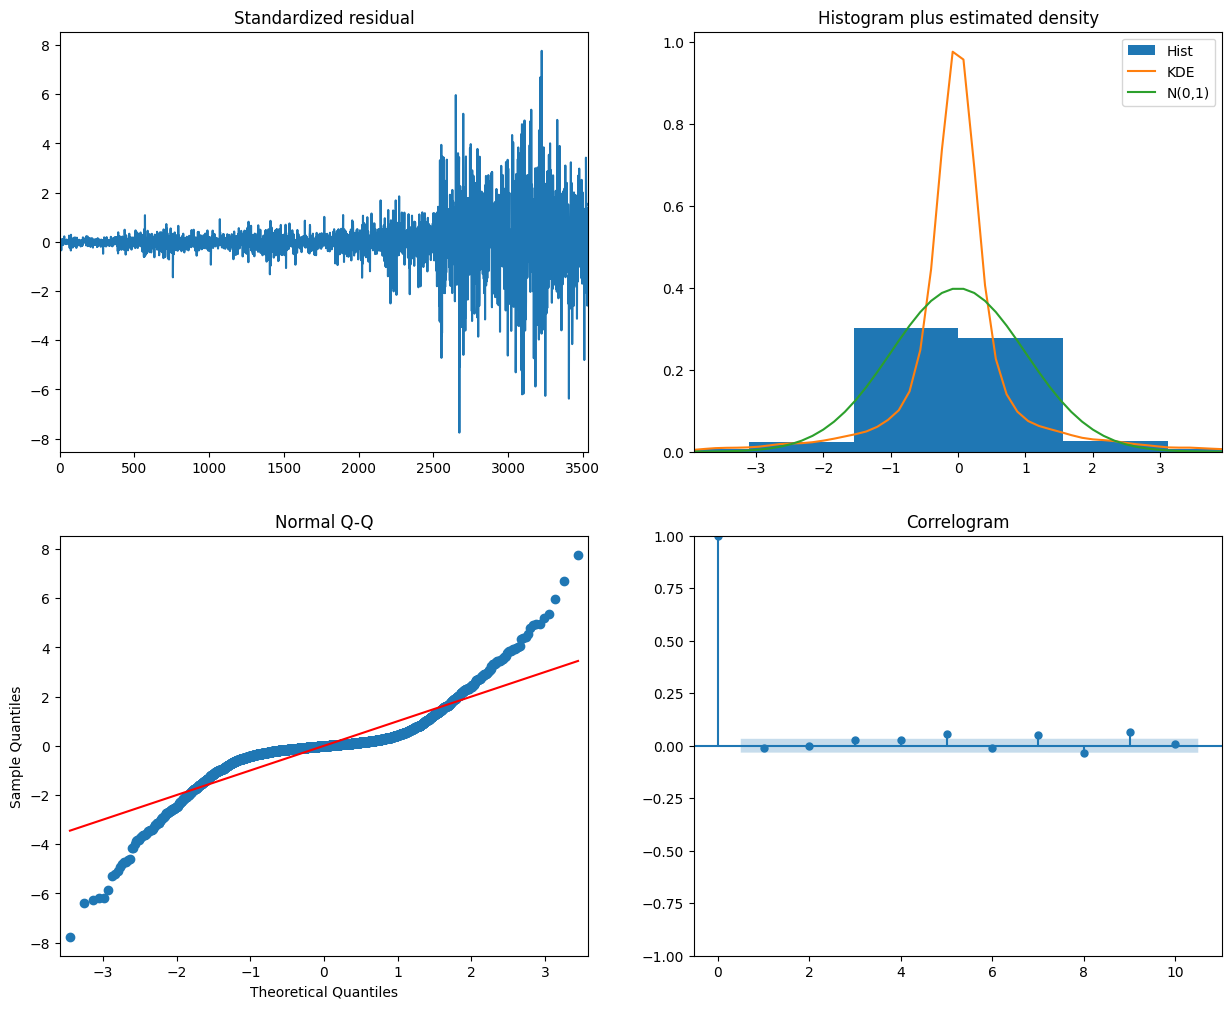

In [7]:
sarima_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [8]:
import pickle
# Serialize with Pickle and save it as pkl
with open('sarima_model.pkl', 'wb') as pkl:
    pickle.dump(sarima_model, pkl)

# Desiarilize the content of the file back into a Python object
with open('sarima_model.pkl', 'rb') as pkl:
    loaded_model = pickle.load(pkl)

In [9]:
def forecast(model, df, forecast_date):
    # Forecast
    n_periods = (datetime.strptime(forecast_date, '%Y-%m-%d') - df.index[-1]).days
    fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    # Make series for plotting purpose
    fitted_series = pd.Series(fitted.values, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    #Concatenate the original DataFrame with forecasted values and confidence intervals
    df_result = pd.concat([df, fitted_series, lower_series, upper_series], axis=1)
    df_result.columns = ["Actual", "Prediction", "Low", "High"]

    #Inverse transform the scaled values to their original scale
    for column in df_result.columns:
      df_result[column] = Feature_Scaler.inverse_transform(df_result[column].values.reshape(-1,1))


    return df_result

In [10]:
test=forecast(loaded_model, apple_transformed, '2024-03-01')

/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [11]:
test

,Actual,Prediction,Low,High
2010-01-04,7.643214,NaN,NaN,NaN
2010-01-05,7.656429,NaN,NaN,NaN
2010-01-06,7.534643,NaN,NaN,NaN
2010-01-07,7.520714,NaN,NaN,NaN
2010-01-08,7.570714,NaN,NaN,NaN
...,...,...,...,...
2024-02-26,NaN,184.342588,172.739450,195.945726
2024-02-27,NaN,184.503847,172.652944,196.354749
2024-02-28,NaN,183.818743,171.744508,195.892979
2024-02-29,NaN,187.324274,175.048270,199.600279


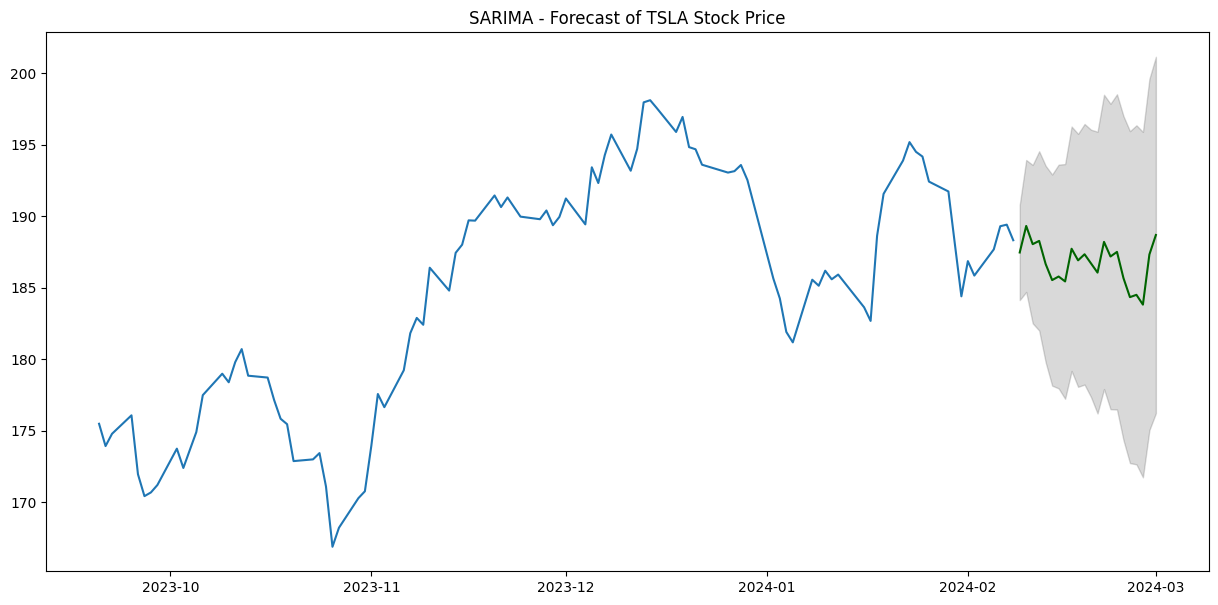

In [12]:
# Plot
plt.figure(figsize=(15,7))
plt.plot(test["Actual"][-120:], color='#1f76b4')
plt.plot(test["Prediction"], color='darkgreen')
plt.fill_between(test.index,
                test["Low"],
                test["High"],
                color='k', alpha=.15)

plt.title("SARIMA - Forecast of TSLA Stock Price")
plt.show()

LSTM MODEL:

In [13]:
apple_data = yf.download("AAPL", start = "2020-01-01", interval = '1d')
apple_df_test = apple_data.reset_index()
apple_df = apple_df_test.copy()

[*********************100%%**********************]  1 of 1 completed


In [14]:
scaler = MinMaxScaler()
data_transformed = pd.DataFrame(
    np.squeeze(
        scaler.fit_transform(
            apple_df[["Close"]])), columns=["Close"], index=apple_df.index)
#data_transformed["Date"] = (datetime)(apple_df["Date"])
#print(data_transformed)

In [15]:
def features_targets(data, feature_length):
    # feature length is the number of time steps in the input sequence
    # targets are the values the model is trying to forecast
    time_step_list, close_label_list = [], []
    
    # iterate through (length of sequential data) to (length of seq data - feature length)
    for i in range(len(data) - feature_length):
        # this will get the vals leading up to the target
        time_steps = data[i : i + feature_length]
        time_step_list.append(time_steps)
        # this will get the target val at this point
        labels = data[i + feature_length]
        close_label_list.append(labels)

    # reshape lists to be suitable for network algo
    time_step_list = np.array(time_step_list).reshape(len(time_step_list), feature_length, 1)
    close_label_list = np.array(close_label_list).reshape(len(close_label_list), 1)

    return time_step_list, close_label_list

In [16]:
time_step_vals, target_vals = features_targets(data_transformed["Close"].values, 20)

In [17]:
train_vals_cutoff = apple_df.loc[apple_df['Date'] >= '2022-01-01']
slice = train_vals_cutoff.shape[0]


In [18]:
def create_model(X, Y, df, data, train_test_slice, scaler):
    # training set: set to train the machine learning model
    # testing set: set used to test model after model has been trained
    # train set is 70% of data, test set is the rest (30%)
    X_train, X_test = X[:-train_test_slice], X[-train_test_slice:]
    Y_train, Y_test = Y[:-train_test_slice], Y[-train_test_slice:]

    # initialize empty model where nodes have input and output with Keras
    model = Sequential()
    # create a bidirectional LSTM: 
    # - 100 cells
    # - return output for input
    # - reduce overfitting w current dropout
    # - specify # of steps for target
    model.add(Bidirectional(LSTM(100, return_sequences=True, recurrent_dropout=0.1, input_shape=(X_train.shape[1], 1))))
    # provide additional processing with undirectional layer
    model.add(LSTM(50, recurrent_dropout=0.1))
    # add dropout and dense layers
    # randomly sets 20% of inputs to 0 to prevent overfitting
    model.add(Dropout(0.2))
    # create a connected layer with 25 output units
    model.add(Dense(20, activation='linear'))
    model.add(Dropout(0.2))
    # create a connected layer with 10 output units
    model.add(Dense(10, activation='linear'))
    # create a connected layer with 1 output unit
    model.add(Dense(1, activation='linear'))

    # optimize model using stochastic gradient descent to train model
    # SGD 
    optimize = tf.keras.optimizers.SGD(learning_rate = 0.002)
    # compile model
    model.compile(loss='mean_squared_error', optimizer=optimize)
    # save model weights validation loss improves
    weights = ModelCheckpoint("best_weights.h5", monitor='val_loss', save_best_only=True, save_weights_only=True)
    # adjust learning rate when needed
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=4, min_lr=0.00001, verbose=1)

    # one epoch completes when the entire training dataset is processed once by the model
    model.fit(X_train, Y_train, epochs=12, batch_size=1, verbose=1, shuffle=False, validation_data=(X_test, Y_test), callbacks=[reduce_lr, weights])
    actual = scaler.inverse_transform(Y_test)
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    actual = np.squeeze(actual, axis=1)
    predictions = np.squeeze(predictions, axis=1)

    #reassign index before it goes into model
    test_df = pd.DataFrame({'Actual': actual, 'Predicted': predictions.flatten()})
    
    #print test_df plot
    '''
    # Plotting test set
    graph.plot(df.index[-train_test_slice:], predictions, label="Predicted")
    graph.plot(df.index[-train_test_slice:], actual, label="Actual")
    graph.xlabel('Date')
    graph.ylabel('Stock Price')
    graph.legend()
    graph.savefig('predicted_stock_prices_lstm3_test.png')
    graph.show()
    '''
    return model, X_train, X_test, Y_train, Y_test

In [19]:
# assign model, x training set, y training set, x testing set, and y testing set
lstm_model, X_train, X_test, Y_train, Y_test = create_model(
        time_step_vals, target_vals, apple_df, data_transformed["Close"].values, slice, scaler)

Epoch 1/12
485/485 [==============================] - 24s 40ms/step - loss: 0.0090 - val_loss: 0.0160 - lr: 0.0020
Epoch 2/12
485/485 [==============================] - 18s 38ms/step - loss: 0.0139 - val_loss: 0.0137 - lr: 0.0020
Epoch 3/12
485/485 [==============================] - 18s 38ms/step - loss: 0.0116 - val_loss: 0.0116 - lr: 0.0020
Epoch 4/12
485/485 [==============================] - 19s 39ms/step - loss: 0.0099 - val_loss: 0.0108 - lr: 0.0020
Epoch 5/12
485/485 [==============================] - 19s 39ms/step - loss: 0.0090 - val_loss: 0.0092 - lr: 0.0020
Epoch 6/12
485/485 [==============================] - 18s 38ms/step - loss: 0.0075 - val_loss: 0.0075 - lr: 0.0020
Epoch 7/12
485/485 [==============================] - 18s 38ms/step - loss: 0.0064 - val_loss: 0.0064 - lr: 0.0020
Epoch 8/12
485/485 [==============================] - 18s 38ms/step - loss: 0.0054 - val_loss: 0.0059 - lr: 0.0020
Epoch 9/12
485/485 [==============================] - 18s 38ms/step - loss: 0.00

In [20]:
# concatenate x sets, horiz axis
total_x = np.concatenate((X_train, X_test), axis = 0)
# concatenate y sets, horiz axis
total_y = np.concatenate((Y_train, Y_test), axis = 0)
# predict x axis with predict function
final_predict = lstm_model.predict(total_x)
# inverse transform x axis predictions
final_predict = scaler.inverse_transform(final_predict)
# inverse transform y predictions
actual = scaler.inverse_transform(total_y)
final_predict = np.squeeze(final_predict, axis = 1)
actual = np.squeeze(actual, axis = 1)

 1/32 [..............................] - ETA: 1s

32/32 [==============================] - 0s 12ms/step


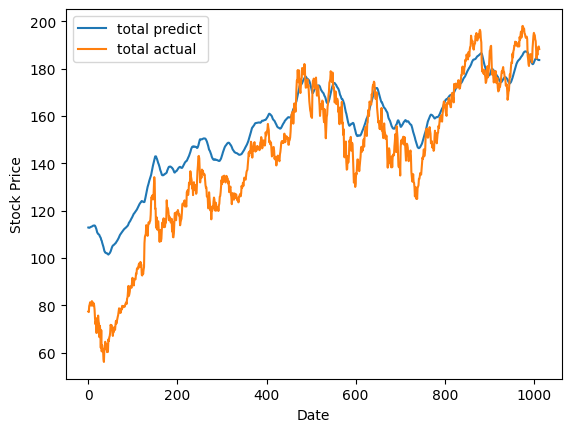

In [21]:
import matplotlib.pyplot as graph
graph.plot(final_predict, label = "total predict")
graph.plot(actual, label = "total actual")
graph.xlabel('Date')
graph.ylabel('Stock Price')
graph.legend()
graph.savefig('test.png')
graph.show()

In [22]:
def predict_lstm(model, df, future_date, scaler, feature_length=20):
    # iterate through today's date until future date
    for i in range((datetime.strptime(future_date, '%Y-%m-%d') - df.index[-1]).days):
        # specify close values
        feature_column = df['Close'].values
        # pick out last 20 days
        time_steps = feature_column[-feature_length:]
        # reshape array
        time_steps = time_steps.reshape(feature_length, 1)
        # scale array
        time_steps = scaler.transform(time_steps)
        prediction = model.predict(time_steps.reshape(1, feature_length, 1))
        prediction = scaler.inverse_transform(prediction)
        # concatenate results with og dataframe
        predicted_vals = pd.DataFrame(prediction, index=[df.index[-1] + timedelta(days=1)], columns=['Close'])
        df = pd.concat([df, predicted_vals])
    return df

In [23]:
print(lstm_model.summary())
lstm_model.predict(data_transformed[-21:-1].values.reshape(1,20,1))
data = pd.DataFrame(apple_data)
test_lstm = predict_lstm(lstm_model, data, '2024-03-01', scaler)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 20, 200)           81600     
 al)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 50)                50200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 20)                1020      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                        

/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 28ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 31ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 26ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 25ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 26ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 28ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 28ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [24]:
# print close values leading up to march 1st
test_lstm.tail(30)

,Open,High,Low,Close,Adj Close,Volume
2024-01-30,190.940002,191.800003,187.470001,188.039993,188.039993,55859400.0
2024-01-31,187.039993,187.100006,184.350006,184.399994,184.399994,55467800.0
2024-02-01,183.990005,186.949997,183.820007,186.860001,186.860001,64885400.0
2024-02-02,179.860001,187.330002,179.250000,185.850006,185.850006,102518000.0
2024-02-05,188.149994,189.250000,185.839996,187.679993,187.679993,69668800.0
2024-02-06,186.860001,189.309998,186.770004,189.300003,189.300003,43490800.0
2024-02-07,190.639999,191.050003,188.610001,189.410004,189.410004,53439000.0
2024-02-08,189.389999,189.539993,187.350006,188.320007,188.320007,40928600.0
2024-02-09,NaN,NaN,NaN,183.646133,NaN,NaN
2024-02-10,NaN,NaN,NaN,183.340988,NaN,NaN


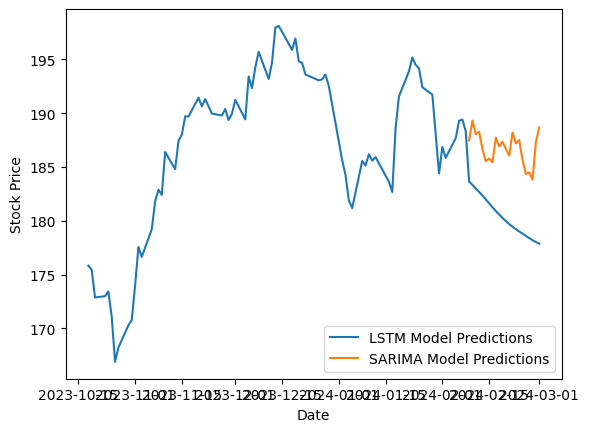

In [25]:
import matplotlib.pyplot as graph
graph.plot(test_lstm["Close"][-100:], label = "LSTM Model Predictions")
graph.plot(test["Prediction"][-100:], label = "SARIMA Model Predictions")
graph.xlabel('Date')
graph.ylabel('Stock Price')
graph.legend()
graph.savefig('test.png')
graph.show()

In [26]:
def forecasting(model, df, forecast_date):
    # Forecast
    n_periods = (datetime.strptime(forecast_date, '%Y-%m-%d') - df.index[-1]).days
    fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    # Make series for plotting purpose
    fitted_series = pd.Series(fitted.values, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    #Concatenate the original DataFrame with forecasted values and confidence intervals
    df_result = pd.concat([df, fitted_series, lower_series, upper_series], axis=1)
    df_result.columns = ["Actual", "Prediction", "Low", "High"]

    #Inverse transform the scaled values to their original scale
    for column in df_result.columns:
      df_result[column] = Feature_Scaler.inverse_transform(df_result[column].values.reshape(-1,1))


    return df_result

def combined_model(data_transformed, lstm_model, sarima_model, forecast_date, scaler):

  #print(data_transformed.tail())
  # create dataframes for high and low values
  df_high = pd.DataFrame(columns=['High'])
  df_low = pd.DataFrame(columns=['Low'])
  #last_initial_date = data_transformed.index[-1]
  # create variable referring to last day
  last_day = data_transformed.index[-1]
  #print(last_day)
  


  # iterate through the number of days between last day and future date
  for i in range((datetime.strptime(forecast_date, '%Y-%m-%d') - data_transformed.index[-1]).days):
    # call prediction function for lstm
    df_lstm_temp = predict_lstm(lstm_model, data_transformed, (data_transformed.index[-1] + timedelta(days=1)).strftime('%Y-%m-%d'), scaler)
    #print(df_lstm_temp.tail())
    # call forecast function for sarima
    df_sarima_temp = forecasting(sarima_model, data_transformed, (data_transformed.index[-1] + timedelta(days=i+1)).strftime('%Y-%m-%d'))
    #print(df_sarima_temp.tail())


    # combine 40% of lstm results and 60% of sarima results for closing vals on last day (day to predict)
    #combination = 0.4 * (scaler.transform(df_lstm_temp.iloc[-1]['Close'].reshape(1,-1))) + 0.6 * (scaler.transform(df_sarima_temp.iloc[-1]['Prediction'].reshape(1,-1)))
    combination = 0.3 * (scaler.transform(test_lstm.iloc[-1]['Close'].reshape(-1,1))) + 0.7 * (scaler.transform(df_sarima_temp.iloc[-1]['Prediction'].reshape(-1,1)))
    print(combination)

    # create new dataframe of combo :D
    forecast = pd.DataFrame(combination, index = [data_transformed.index[-1] + timedelta(days=1)], columns = ['Close'])
    data_transformed = pd.concat([data_transformed, forecast])
    # create new dataframe of low values
    df_low = pd.concat([df_low, pd.DataFrame(df_sarima_temp.iloc[-1]['Low'],
                                          index=[data_transformed.index[-1]+ timedelta(days=1)],
                                          columns=['Low'])
    ])
    # create new dataframe of high values
    df_high = pd.concat([df_high, pd.DataFrame(df_sarima_temp.iloc[-1]['High'],
                                          index=[data_transformed.index[-1]+ timedelta(days=1)],
                                          columns=['High'])
    ])

  # squeeze final results to one axis, and inverse transform
  df_final = pd.DataFrame(np.squeeze(scaler.inverse_transform(data_transformed)),
                        index=data_transformed.index, columns=['Close'])

  #print(df_final.tail())

  # final actual df values are all days leading up to last day that has occurred
  df_final_actual = df_final[:last_day + timedelta(days=1)]
  # final predicted df values are all future days
  df_final_prediction = df_final[last_day + timedelta(days=1):]
  print(df_final_prediction.tail())

  return df_final_actual, df_final_prediction, df_low,  df_high



In [27]:
# get ~final~ combined results
combined_actual, combined_prediction, combined_df_low, combined_df_high = combined_model(apple_transformed, lstm_model, sarima_model, '2024-03-01', scaler)

1/1 [==============================] - 0s 29ms/step


[[0.90478742]]
1/1 [==============================] - 0s 30ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid 

[[0.91392918]]
1/1 [==============================] - 0s 28ms/step
[[0.90765831]]
1/1 [==============================] - 0s 30ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without

[[0.90878329]]
1/1 [==============================] - 0s 29ms/step
[[0.90080925]]
1/1 [==============================] - 0s 29ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without

[[0.89527647]]
1/1 [==============================] - 0s 26ms/step
[[0.89650807]]
1/1 [==============================] - 0s 26ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without

[[0.89481428]]
1/1 [==============================] - 0s 25ms/step
[[0.90607394]]
1/1 [==============================] - 0s 26ms/step
[[0.90207737]]
1/1 [==============================] - 0s 27ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid 

[[0.90417169]]
1/1 [==============================] - 0s 27ms/step
[[0.90101207]]
1/1 [==============================] - 0s 26ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without

[[0.89785809]]
1/1 [==============================] - 0s 27ms/step
[[0.90843806]]
1/1 [==============================] - 0s 31ms/step
[[0.90340333]]
1/1 [==============================] - 0s 27ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid 

[[0.90499056]]
1/1 [==============================] - 0s 27ms/step
[[0.89596374]]
1/1 [==============================] - 0s 27ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without

[[0.88940236]]
1/1 [==============================] - 0s 27ms/step
[[0.8901972]]
1/1 [==============================] - 0s 29ms/step
[[0.88682034]]


/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid 

1/1 [==============================] - 0s 31ms/step
[[0.904099]]
1/1 [==============================] - 0s 28ms/step
[[0.91081816]]
                 Close
2024-02-26  182.403200
2024-02-27  182.516081
2024-02-28  182.036508
2024-02-29  184.490380
2024-03-01  185.444618


/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid 

In [28]:
print(combined_actual.tail())

                 Close
2024-02-05  190.364979
2024-02-06  191.567952
2024-02-07  191.649635
2024-02-08  190.840235
2024-02-09  184.588147


In [29]:
print(combined_prediction.tail())

                 Close
2024-02-26  182.403200
2024-02-27  182.516081
2024-02-28  182.036508
2024-02-29  184.490380
2024-03-01  185.444618


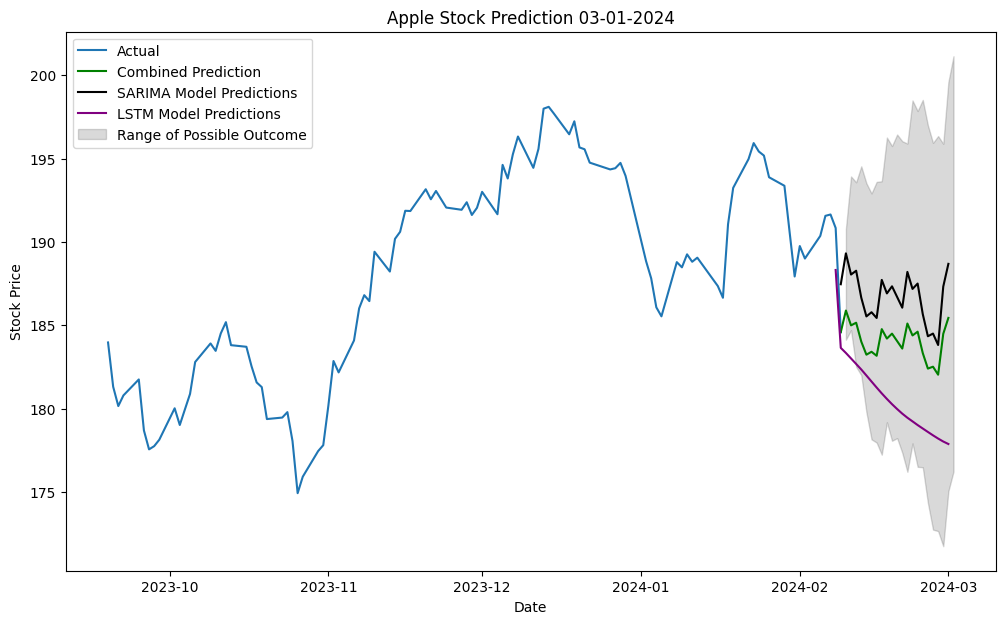

                 Close
2024-02-09  184.588147
2024-02-10  185.886437
2024-02-11  184.995864
2024-02-12  185.155631
2024-02-13  184.023178
2024-02-14  183.237426
2024-02-15  183.412335
2024-02-16  183.171787
2024-02-17  184.770856
2024-02-18  184.203274
2024-02-19  184.500703
2024-02-20  184.051982
2024-02-21  183.604061
2024-02-22  185.106602
2024-02-23  184.391583
2024-02-24  184.616997
2024-02-25  183.335032
2024-02-26  182.403200
2024-02-27  182.516081
2024-02-28  182.036508
2024-02-29  184.490380
2024-03-01  185.444618


In [42]:

graph.figure(figsize=(12,7))
graph.plot(combined_actual.tail(100), color='#1f76b4', label = "Actual")
graph.plot(combined_prediction, color='green', label = "Combined Prediction")
graph.plot(test['Prediction'][-30:], color = 'black', label = "SARIMA Model Predictions")
graph.plot(test_lstm['Close'][-23:], color = 'purple', label = "LSTM Model Predictions")
graph.fill_between(combined_df_low.index,
                combined_df_low["Low"],
                combined_df_high["High"],
                color='k', alpha=.15, label = "Range of Possible Outcome")
graph.xlabel('Date')
graph.ylabel('Stock Price')
graph.legend()
graph.title("Apple Stock Prediction 03-01-2024")
graph.show()
print(combined_prediction)


In [31]:

# specify google cloud project information
dataset_id = 'predicted_prices'
table_id = 'SARIMA and LTSM Predicted Prices'
table_path = f"{project_id}.{dataset_id}.{table_id}"

# specify load reqs
load_info = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
# enter combined data load_data = client.load_table_from_dataframe(combined data, table_path, job_config=load_info)
load_data.result()

LoadJob<project=black-vehicle-406619, location=US, id=50417b67-de88-4667-ba47-4c93d31a93e2>